0.09287981859410431


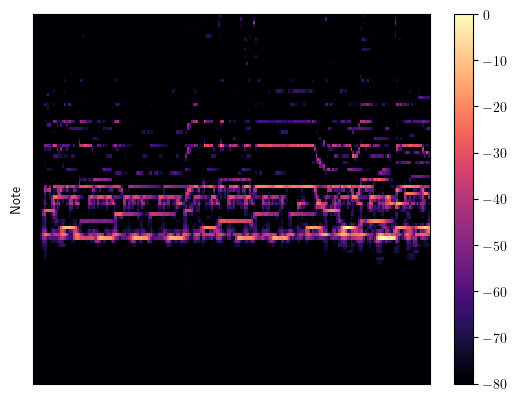

In [2]:
import librosa
import features
import matplotlib.pyplot as plt
import matplotlib.patches
import utils
import numpy as np
import mir_eval
import matplotlib.gridspec 
from scipy.fftpack import dct,idct
from utils import buffer
import scipy
import madmom

plt.rcParams['text.usetex'] = True

start = 0
stop = 20
path = "/home/max/ET-TI/Masterarbeit/mirdata/beatles/"
# title = "06_-_Rubber_Soul/11_-_In_My_Life"
# title = "12_-_Let_It_Be/06_-_Let_It_Be"
title = "10CD1_-_The_Beatles/CD1_-_17_-_Julia"

y,sr = librosa.load(path+"/audio/"+title+".wav",offset=start,duration=stop-start,sr=44100)
target = mir_eval.io.load_labeled_intervals(path+"/annotations/chordlab/The Beatles/"+title+".lab",' ','#')


beat_processor = madmom.features.downbeats.DBNDownBeatTrackingProcessor(2,fps=100)
activation_processor =  madmom.features.downbeats.RNNDownBeatProcessor()
activations = activation_processor(path+"/audio/"+title+".wav")
beats = beat_processor(activations)

n = 2**14
hopsize = n // 4
overlap = n-hopsize
print((n-overlap) / sr)
midi_note_start = 12  # C1
octaves = 8
midi_note_stop = midi_note_start + 12 * octaves
####### STFT  ########
k = np.arange(0,n//2 + 1)
fk = k*(sr/n)  # DFT-bin frequencies
midi_note_number_frequencies = 12* np.log2((fk/440)+np.finfo(float).eps)+69

Hp = np.zeros((fk.shape[0],midi_note_stop - midi_note_start),dtype=float)
for i, midi_note_number in enumerate(range(midi_note_start,midi_note_stop)):
    d = np.abs(midi_note_number - midi_note_number_frequencies)
    Hp[:,i] = 0.5 * np.tanh(np.pi * (1 - 2*d)) + 0.5

window = np.hanning(n)
y_blocks = buffer(y,n,overlap,0,window) 
weight = np.sum(window)
y_spectrum = (2/weight) * np.abs(np.fft.rfft(y_blocks,axis=0))
v = np.matmul(Hp.T, y_spectrum) ** 2   # np.power(X,2) 

pitch_gram_stft = np.finfo(float).eps * np.ones((midi_note_stop,v.shape[1]))
pitch_gram_stft[12:,:] = v
time_vector_stft = np.linspace(start+n/2/sr, stop, v.shape[1], endpoint=False) 
####### CQT ########
bins_per_octave = 36
midi_note_start = 12
octaves = 8

estimated_tuning = librosa.estimate_tuning(y=y,bins_per_octave=bins_per_octave)
C = np.abs(librosa.vqt(y, sr=sr,fmin=librosa.midi_to_hz(midi_note_start),
                       bins_per_octave=bins_per_octave,n_bins=bins_per_octave*octaves,
                         hop_length=4096,tuning=estimated_tuning,gamma=0))

# pick every third coefficient from oversampled cqt
pitchgram_cqt = np.finfo(float).eps * np.ones((midi_note_stop,C.shape[1])) 
for note in range(midi_note_start,midi_note_stop):
    pitchgram_cqt[note,:] = C[(note-midi_note_start)*3,:]
pitchgram_cqt = pitchgram_cqt ** 2
time_vector_cqt = np.linspace(start, stop, C.shape[1], endpoint=False) 
fig,ax =plt.subplots()
img=librosa.display.specshow(librosa.amplitude_to_db(pitchgram_cqt,ref=np.max(pitchgram_cqt)),fmin=librosa.midi_to_hz(0),y_axis='cqt_note',bins_per_octave=12,ax=ax)
plt.colorbar(img)

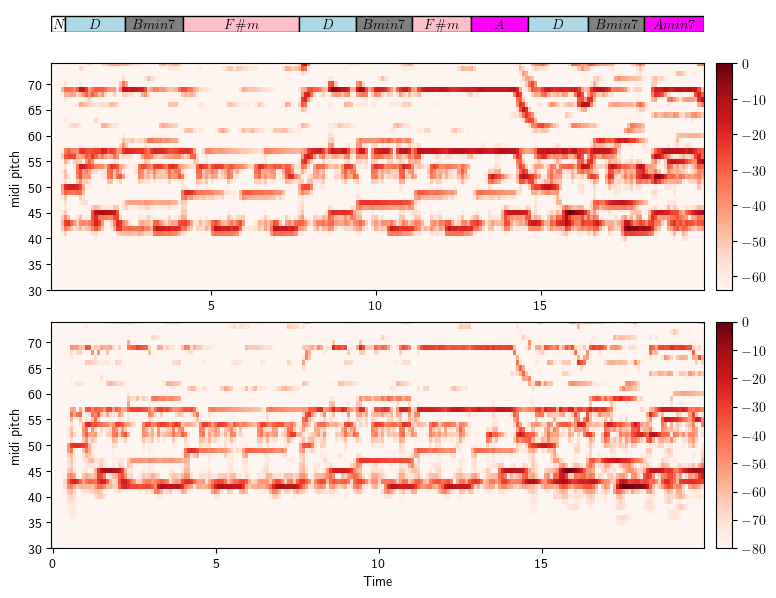

In [3]:

fig = plt.figure(figsize=(10, 7))
gs = matplotlib.gridspec.GridSpec(3, 3,width_ratios=(40,1,5),height_ratios=(1,10,10), hspace=0.2,wspace=0.05)
utils.plotChordAnnotations(fig.add_subplot(gs[0,0]),target,(start,stop))

ax = fig.add_subplot(gs[1,0])
img = librosa.display.specshow(librosa.amplitude_to_db(pitch_gram_stft,ref=np.max(pitch_gram_stft)),x_coords=time_vector_stft,x_axis='time',cmap="Reds", ax=ax)
ax.set_ylim(30,74)
ax.set_yticks(range(30,70+5,5))
ax.set_yticklabels(range(30,70+5,5))
ax.set_ylabel("midi pitch")
ax.set_xlabel("")
fig.colorbar(img,cax=fig.add_subplot(gs[1,1]))

ax = fig.add_subplot(gs[2,0])
img = librosa.display.specshow(librosa.amplitude_to_db(pitchgram_cqt,ref=np.max(pitchgram_cqt)),x_coords=time_vector_cqt,x_axis='time',cmap="Reds", ax=ax)
ax.set_ylim(30,74)
ax.set_yticks(range(30,70+5,5))
ax.set_yticklabels(range(30,70+5,5))
ax.set_ylabel("midi pitch")
fig.colorbar(img,cax=fig.add_subplot(gs[2,1]));

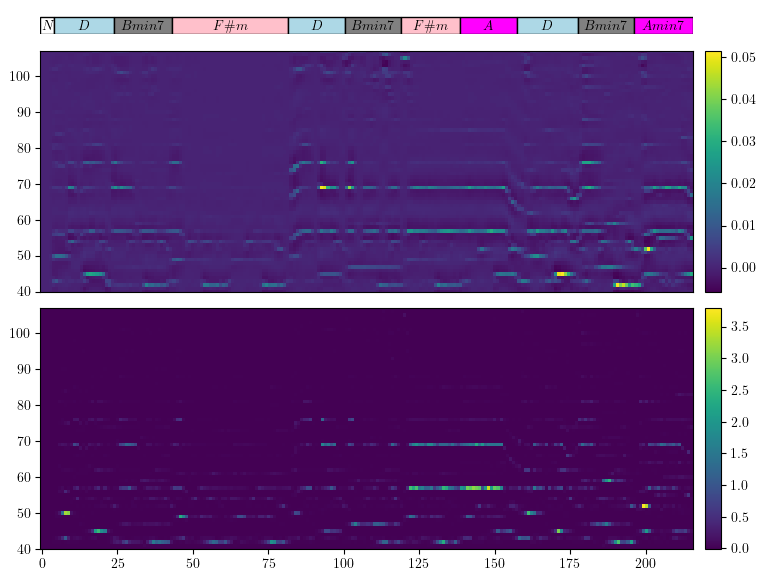

In [4]:

#### liftering #####
nCRP = 22  # 22 ... 60
vLog = np.log(1000 * pitch_gram_stft + 1);   
vLogDCT = dct(vLog, norm='ortho', axis=0);  
vLogDCT[:nCRP,:] = 0  # liftering hochpass
vLogDCT[nCRP,:] = 0.5 * vLogDCT[nCRP,:]
vLog_lift = idct(vLogDCT, norm='ortho', axis=0)
pitch_gram_stft_lift = 1/100 * (np.exp(vLog_lift)-1); 

vLog = np.log(1000 * pitchgram_cqt + 1); 
vLogDCT = dct(vLog, norm='ortho', axis=0);  
vLogDCT[:nCRP,:] = 0  # liftering hochpass
vLogDCT[nCRP,:] = 0.5 * vLogDCT[nCRP,:]
vLog_lift = idct(vLogDCT, norm='ortho', axis=0)
pitch_gram_cqt_lift = 1/100 * (np.exp(vLog_lift)-1); 

fig = plt.figure(figsize=(10, 7))
gs = matplotlib.gridspec.GridSpec(3, 3,width_ratios=(40,1,5),height_ratios=(1,10,10), hspace=0.1,wspace=0.05)
utils.plotChordAnnotations(fig.add_subplot(gs[0,0]),target,(start,stop))

ax = fig.add_subplot(gs[1,0])
img = ax.imshow(pitch_gram_stft_lift,origin="lower",aspect='auto')
ax.set_ylim(40,midi_note_stop-1)
ax.set_xticks([])
fig.colorbar(img,cax=fig.add_subplot(gs[1,1]))

ax = fig.add_subplot(gs[2,0])
img = ax.imshow(pitch_gram_cqt_lift,origin="lower",aspect='auto')
ax.set_ylim(40,midi_note_stop-1)
fig.colorbar(img,cax=fig.add_subplot(gs[2,1]));


[0.52 1.  ]
[1.44 2.  ]
[2.32 1.  ]
[3.24 2.  ]
[4.12 1.  ]
[5.04 2.  ]
[5.9 1. ]
[6.83 2.  ]
[7.71 1.  ]
[8.55 2.  ]
[9.41 1.  ]
[10.33  2.  ]
[11.17  1.  ]
[12.08  2.  ]
[12.95  1.  ]
[13.83  2.  ]
[14.76  1.  ]
[15.67  2.  ]
[16.53  1.  ]
[17.45  2.  ]
[18.33  1.  ]
[19.24  2.  ]
[20.13  1.  ]
[20.98  2.  ]
[21.84  1.  ]
[22.76  2.  ]
[23.68  1.  ]
[24.57  2.  ]
[25.46  1.  ]
[26.39  2.  ]
[27.25  1.  ]
[28.15  2.  ]
[29.04  1.  ]
[29.93  2.  ]
[30.83  1.  ]
[31.68  2.  ]
[32.61  1.  ]
[33.47  2.  ]
[34.34  1.  ]
[35.22  2.  ]
[36.11  1.  ]
[36.99  2.  ]
[37.9  1. ]
[38.81  2.  ]
[39.71  1.  ]
[40.6  2. ]
[41.5  1. ]
[42.4  2. ]
[43.29  1.  ]
[44.2  2. ]
[45.08  1.  ]
[46.  2.]
[46.89  1.  ]
[47.75  2.  ]
[48.67  1.  ]
[49.57  2.  ]
[50.49  1.  ]
[51.35  2.  ]
[52.24  1.  ]
[53.1  2. ]
[54.03  1.  ]
[54.9  2. ]
[55.79  1.  ]
[56.67  2.  ]
[57.59  1.  ]
[58.49  2.  ]
[59.35  1.  ]
[60.25  2.  ]
[61.14  1.  ]
[62.03  2.  ]
[62.89  1.  ]
[63.77  2.  ]
[64.66  1.  ]
[65.56  2.  ]
[66.47

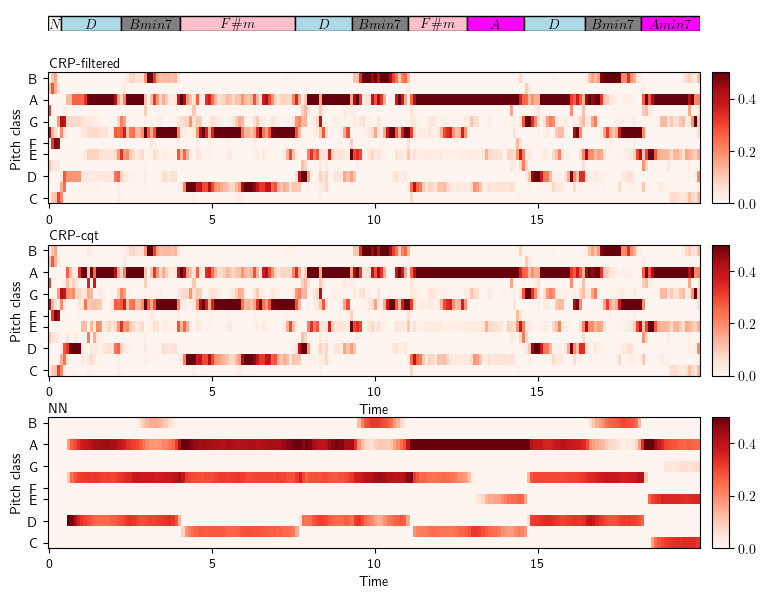

In [6]:
### pitch folding ###
chroma_stft = pitch_gram_stft_lift.reshape(midi_note_stop//12,12,-1)
chroma_stft = np.maximum(0, np.sum(chroma_stft, axis=0))
chroma_stft = chroma_stft / np.sum(chroma_stft,axis=0)
chroma_stft = chroma_stft.T

chroma_cqt = pitch_gram_cqt_lift.reshape(midi_note_stop//12,12,-1)
chroma_cqt = np.maximum(0, np.sum(chroma_cqt, axis=0))
chroma_cqt = chroma_cqt / np.sum(chroma_cqt,axis=0)
chroma_cqt = chroma_cqt.T

time_vector = np.linspace(start, stop, chroma_cqt.shape[0], endpoint=False)

chroma_aligned = np.copy(chroma_cqt)


# Calulate the number of frames within the time interval
for b0,b1 in zip(beats[:-1],beats[1:]):
    # find closest index in chroma vector
    try:
        idx0 = np.argwhere(time_vector >= b0[0])[0][0]
    except IndexError:
        # no matching interval found at array boundaries
        idx1 = 0
    try:
        idx1 = np.argwhere(time_vector >= b1[1])[0][0]
    except IndexError:
        idx1 = time_vector.shape[0]  
    # use non-local filtering
    try:
        chroma_filter = np.minimum(chroma_aligned[idx0:idx1,:],
                            librosa.decompose.nn_filter(chroma_aligned[idx0:idx1,:],
                            axis=0,
                            aggregate=np.median,
                            metric='cosine'))
    except ValueError:
        chroma_filter = chroma_aligned[idx0:idx1,:]
    # apply horizontal median filter
    chroma_aligned[idx0:idx1,:] = scipy.ndimage.median_filter(chroma_filter, size=(9, 1))
fig = plt.figure(figsize=(10, 7))
gs = matplotlib.gridspec.GridSpec(4, 3,width_ratios=(40,1,5),height_ratios=(1,6,6,6), hspace=0.4,wspace=0.05)

utils.plotChordAnnotations(fig.add_subplot(gs[0,0]),target,(start,stop))
ax00 = fig.add_subplot(gs[1,0])
ax01 = fig.add_subplot(gs[1,1])
img = utils.plotChromagram(ax00,time_vector,chroma_aligned)
ax00.text(0,12,"CRP-filtered")
ax00.set_xlabel("")
fig.colorbar(img,cax=ax01)

ax10 = fig.add_subplot(gs[2,0])
ax11 = fig.add_subplot(gs[2,1])
img = utils.plotChromagram(ax10,time_vector,chroma_cqt);
ax10.text(0,12,"CRP-cqt")
ax00.set_xlabel("")
fig.colorbar(img,cax=ax11);

deep_chroma = features.deepChroma(y,split_nr=4)
time_vector = np.linspace(start, stop, deep_chroma.shape[0], endpoint=False)
ax20 = fig.add_subplot(gs[3,0])
ax21 = fig.add_subplot(gs[3,1])
img = utils.plotChromagram(ax20,time_vector,deep_chroma);
ax20.text(0,12,"NN")
ax00.set_xlabel("")
fig.colorbar(img,cax=ax21);


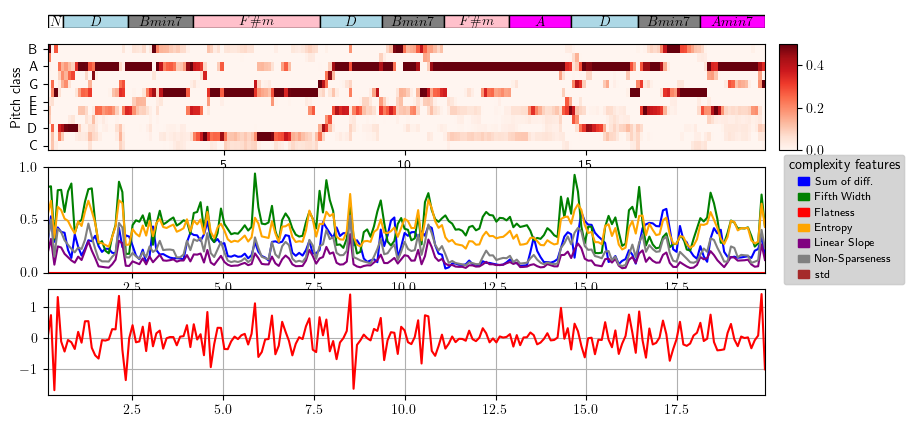

In [ ]:
fig = plt.figure(figsize=(11, 5))
gs = matplotlib.gridspec.GridSpec(4,3,width_ratios=(40,1,5),height_ratios=(1,6,6,6), hspace=0.2,wspace=0.05)
ax00 = fig.add_subplot(gs[0,0])
ax10 = fig.add_subplot(gs[1,0])
ax11 = fig.add_subplot(gs[1,1])
ax20 = fig.add_subplot(gs[2,0])
ax21 = fig.add_subplot(gs[2,1:])
ax30 = fig.add_subplot(gs[3,0])
utils.plotChordAnnotations(ax00,target,(start,stop))
img = utils.plotChromagram(ax10,time_vector_stft,chroma_stft)
fig.colorbar(img,cax=ax11);
# features
complexity_features = [
                features.sumChromaDifferences(chroma_stft),
                features.angularDeviation(chroma_stft),
                features.flatness(chroma_stft),
                features.shannonEntropy(chroma_stft),
                features.negativeSlope(chroma_stft),
                features.nonSparseness(chroma_stft)
]
complexity_sum = np.zeros_like(time_vector_stft)
complexity_diff = np.zeros_like(time_vector_stft)
for x in complexity_features:
    complexity_sum += x
complexity_diff[1:] = np.diff(complexity_sum)
colors = ["blue", "green", "red", "orange", "purple", "grey","brown", "black"]
ax20.plot(time_vector_stft, complexity_features[0],color=colors[0])
ax20.plot(time_vector_stft, complexity_features[1],color=colors[1])
ax20.plot(time_vector_stft, complexity_features[2],color=colors[2])
ax20.plot(time_vector_stft, complexity_features[3],color=colors[3])
ax20.plot(time_vector_stft, complexity_features[4],color=colors[4])
ax20.plot(time_vector_stft, complexity_features[5],color=colors[5])
ax20.set_xlim(time_vector_stft[0],time_vector_stft[-1])
ax20.set_ylim(0,1)
ax20.grid(True)
#create legend
labels = ['Sum of diff.',"Fifth Width","Flatness","Entropy","Linear Slope","Non-Sparseness","std"]
legend_handles = [matplotlib.patches.Patch(color=color) for color in colors]
legend = ax21.legend(legend_handles, labels, loc='center left', bbox_to_anchor=(0, 0.5), title='complexity features', handlelength=1, handletextpad=0.5, fontsize=8, title_fontsize=10, facecolor='lightgray', framealpha=0.8)
ax21.add_artist(legend)
ax21.set_axis_off()
ax30.plot(time_vector_stft,complexity_diff,'r')
ax30.set_xlim(time_vector_stft[0],time_vector_stft[-1])
ax30.grid(True)
plt.show()